In [ ]:
!pip install -U tensorflow
!pip install tensorflow_decision_forests

Coding a supervised model to predict house prices based on their area, how many rooms and location

In [72]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [95]:
# Importing train dataset and taking a first look at it
dataset = pd.read_csv(r'train.csv')

# According to Kaggle, the column SalePrice is the target
dataset.shape

(1460, 81)

In [74]:
# Since there is a lot of columns, lets loop through it to see if there are Na values
lenght = len(dataset)
na_columns = []
for i in dataset.columns:
  x = dataset[i].count()
  if x != lenght:
    na_columns.append(i)

In [75]:
# Filling NA columns of dtype == object with a new class: Unknown and with the median in other cases
for column in na_columns:
  if dataset[column].dtype == 'object':
    dataset[column] = dataset[column].fillna('Unknown')

  elif dataset[column].dtype == 'float64':
    dataset[column] = dataset[column].fillna(dataset[column].median())

In [76]:
# Droping the ID column since it is not necessary
dataset.drop(['Id'], axis=1, inplace=True)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

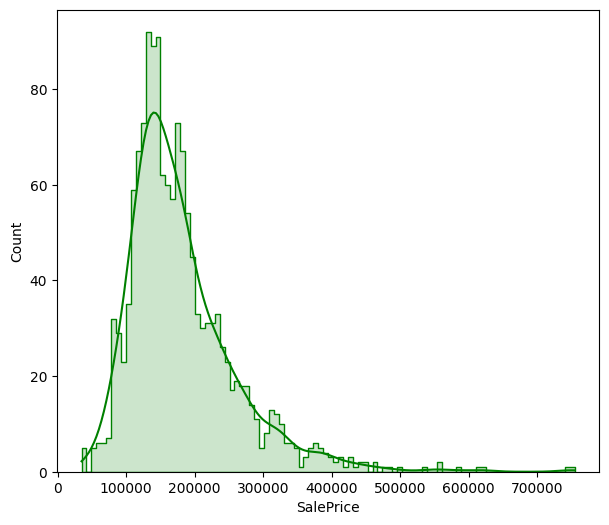

In [146]:
# Now let us take a look at how the house prices are distributed.
print(dataset['SalePrice'].describe())
plt.figure(figsize=(7, 6))
sns.histplot(data=dataset, x='SalePrice', color='g', bins=100, kde=True, element='step', alpha=0.2)